# Feature Selection with Randomized Optimization - MIMIC

Feature selection with randomized optimization. Why randomized optimization? Because ..., why not? Whenever a function is non-derivable or its domain is discrete, randomized optimization is there for you, and feature selection problem is no exception.

## Simplicity

We keep things simple: only a modular feature extraction section is added and for the sake of simplicity, all features are discretized. Categories are encoded, continuous ones are split into bins and again encoded. No fine-granuled rules such as **Masters live**, this is purely extract-and-dump style.

## Believing in Search
Yes, we believe in search, but not brute search. Intelligent, informative search with a structured approach can yield a consisten set of features with high generalization ability for any model. 

For this application, we go back in time and bring back Mutual-Information Maximizing Input Clustering (MIMIC)[[1]] algorithm by Charles Isbell et. al. for feature selection.

## MIMIC

MIMIC is a population based incremental learning algorithm *which attempts to communicate information about the cost function obtained from one iteration of the search to later iterations of the search*. In simple terms, this is done by creating a dependency tree of variables and calculating emprical conditional probability of variables at each iteration while gradually raising fitness threshold to retain candidates, resulting in fitness of candidate set eventually converging to optimum.

### Adaptation to Feature Selection

By appropriately defining a fitness function, randomized optimization algorithms can be adapted to most tasks. In our case, fitness function is average test score of a 10-fold cross validation process where a logistic regression model is trained and evaluated by features selected by MIMIC.

### Expensive Overhead

Compared to other randomized optimization algorithms, MIMIC has a high overhead because of inner loop consisting of mutual information calculation, dependency tree construction, conditional probability estimation and resampling. However, number of function evaluations (10-fold cross validations in this case) is also considerably fewer due to communication of cost function information.

Below is MIMIC's performance in K-coloring problem compared to other algorithms [[1]]

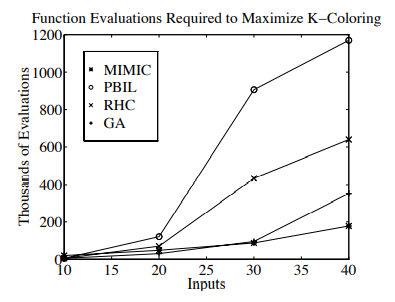

Therefore, MIMIC is better suited for scenarios where cost of function evaluation is relatively high (after all, make it worth while). Throw in your most dreaded stacked ensembled reinforced learners.

### Implementation

MIMIC implementation we use in this application is per `randopts` [[2]] package, providing the algorithm itself with a twist (correlation coefficient as a faster yet still usable approximation of mutual info gain). `randopts` also features some handy API to make adaption of any task easier.

(Disclaimer: this code base has nothing to do with CS-7641 Machine Learning (winks) )

## Model

To further highlight the power of feature selection and how it works with any model, we stay away from abysmally stacked ensembles of models and use ONE simple logistic regression model.

[1]: https://www.cc.gatech.edu/~isbell/papers/isbell-mimic-nips-1997.pdf "Mutual-Information Maximizing Input Clustering (MIMIC)"

[2]: https://github.com/sukruc/randopts "sukruc/randopts"


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, svm, datasets, linear_model, random_projection, feature_selection, feature_extraction, preprocessing, model_selection, feature_selection, metrics, decomposition, cluster, pipeline, impute, compose, ensemble, random_projection
import seaborn as sns
import os
from ipywidgets import interact
import warnings

In [ ]:
warnings.simplefilter("ignore")

In [ ]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [ ]:
def pipe_info(x):
    """Once in a while, you may want to know what is going on in your pipeline."""
    print(x.shape)
    return x

`randopts` can be installed using code snippet below.

In [ ]:
!pip install git+https://github.com/sukruc/randopts.git
!pip install bitstring

In [ ]:
import randopts as rnd

We hold out 10% of data, but we really don't do anything with it here. Feel free to use it as your test set.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df.drop('Survived',1 ), df['Survived'], test_size=0.1)

## Feature Transformer Pipeline
As discussed in introduction, a pipeline is featured to apply some transformations and yield binary features from original raw dataset. Second order interactions are included as AND operatores. As squared binary variables are equal to themselves, we only include interactions by using a `FeatureUnion` and save 2,000 redundant features! (total number of features at this point is 1M)

In [ ]:
cabin_tr = compose.ColumnTransformer([
    ('p_cabin', pipeline.Pipeline([
        ('impute', impute.SimpleImputer(strategy='constant', fill_value='U00')),
        ('cabin_name', preprocessing.FunctionTransformer(lambda x: pd.DataFrame(x)[0].str[0].to_frame().values)),
        ('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ]), ['Cabin']),
    ('p_sex', pipeline.Pipeline([
        ('impute', impute.SimpleImputer(strategy='most_frequent')),
        ('binarize', preprocessing.OneHotEncoder(drop='first'))
    ]), ['Sex']),
    ('p_age', pipeline.Pipeline([
        ('impute', impute.SimpleImputer(strategy='median')),
        ('discretize', preprocessing.KBinsDiscretizer(n_bins=10))
    ]), ['Age']),
    ('p_class', pipeline.Pipeline([
        ('impute', impute.SimpleImputer(strategy='most_frequent')),
        ('encode', preprocessing.OneHotEncoder(drop='first'))
    ]), ['Pclass']),
    ('p_name', pipeline.Pipeline([
        ('impute', impute.SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('tolist', preprocessing.FunctionTransformer(lambda x: x.T[0].tolist())),
        ('encode', feature_extraction.text.CountVectorizer(min_df=0.0))
    ]), ['Name']),
], remainder='drop')
feature_pipe = pipeline.Pipeline([
        ('tr', cabin_tr),
        ('union', pipeline.FeatureUnion([
            ('poly', preprocessing.PolynomialFeatures(2, include_bias=False, interaction_only=True)),
            ('dummy', preprocessing.FunctionTransformer(lambda x: x))
            ])),
#         ('count', preprocessing.FunctionTransformer(pipe_info)),  # uncomment to print shape at this point
#         ('projector1', random_projection.GaussianRandomProjection(n_components=1000)),
        ('cluster', cluster.KMeans(n_clusters=100)),
        ('projector2', random_projection.GaussianRandomProjection(n_components=500)),
#         ('binarizer', preprocessing.Binarizer()),
#         ('scale', preprocessing.MaxAbsScaler()),
#         ('standardize', preprocessing.StandardScaler()),

])

An interpreter maker wrapper function is provided below to communicate between optimizer and pipeline.

In [ ]:
def interpreter_func(X, y, transformer, classifier, **cv_args):
    """An interpreter function wrapper to communicate between optimizer,
    transformation pipeline and the model.
    
    Args:
    ----------
        X: pd.DataFrame, raw dataset
        y: pd.DataFrame, pd.Series or numpy.ndarray, target variables
        classifier: sklearn-like estimator instance
        **cv_args: keyword arguments to pass on `model_selection.cross_validate` function.
        
    Returns:
    ----------
        fitness_func: a callable that takes a bit string and yields a fitness score 
    """
    print("Creating wrapper... This may take a while.")
    X_ = transformer.fit_transform(X)
    print("Done.")
    def fitness_func(support_bits: str):
        support = [bool(int(i)) for i in list(support_bits)]
        Xselect = X_[:, support]
        score = model_selection.cross_validate(classifier, Xselect, y, return_train_score=True, **cv_args)['test_score'].mean()
        return score
    return fitness_func

The cell below is the heart of feature selection. 

## MIMIC

MIMIC allows user to adjust a set of parameters such as population size, fitness shrinkage (set to 0.5 median population fitness by default

## HillClimber

As a comparison, we also provide `HillClimber`. Uncomment `HillClimber` line to see how it works and compare to MIMIC. (Pass an integer N to `random_neighbors` argument to speed up search by only using a subset of N neighbors at each iteration.)

Now, this will take a while. Take a break, write some code, do what you do best.

In [ ]:
Xsmp = feature_pipe.fit_transform(
    X_train,
)
problem = rnd.problem.CustomProblem(
    interpreter_func(
        X_train,
        y_train,
        feature_pipe,
#         svm.LinearSVC(),
        linear_model.LogisticRegression(max_iter=10000),
        cv=model_selection.StratifiedKFold(n_splits=(10 // (1 + 1 + 1))),
        n_jobs=-1,
        ),
    nbits=Xsmp.shape[1]
    )
# optimizer = rnd.solver.HillClimber(verbose=1, random_neighbors=None, maksiter=100)
optimizer = rnd.solver.MIMIC(verbose=1, gain_func='corr', patience=10, population_size=100)
optimizer.fit(problem)
optimizer.ara(problem)
print(optimizer.best)

In [ ]:
plt.plot(optimizer.solution_arr)
plt.semilogx()
plt.grid()
plt.xlabel('Function evaluations')
plt.ylabel('Average Test Accuracy (10-folds)')
plt.title('MIMIC performance vs function evaluations')

In [ ]:
X_ = feature_pipe.transform(df.drop('Survived', 1))
y_ = df['Survived']
model = linear_model.LogisticRegression()
support = [bool(int(i)) for i in optimizer.best]
model.fit(X_[:, support], y_)

In [ ]:
feature_pipe.transform(df_test)[:, support].shape

In [ ]:
pd.DataFrame(model_selection.cross_validate(model, X_[:, support], y_, return_train_score=True)).mean()

In [ ]:
pred = pd.Series(model.predict(feature_pipe.transform(df_test)[:, support]), index=df_test['PassengerId']).rename('Survived')

In [ ]:
pred.to_csv('/kaggle/working/predictions.csv')